## HW3: Decision Tree, Random Forest, and Adaboost
In hw3, you need to implement decision tree, random forest and adaboost by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [363]:
!pip install sklearn

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## Load data

In [364]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter

In [365]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [366]:
x_train = pd.read_csv("x_train.csv").to_numpy()
y_train = pd.read_csv("y_train.csv").to_numpy()
x_test = pd.read_csv("x_test.csv").to_numpy()
y_test = pd.read_csv("y_test.csv").to_numpy()

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from the course slides on E3

In [367]:
def gini(sequence):
    ret = 0
    for i in np.unique(sequence, return_counts=True)[1]:
        ret += pow(i / len(sequence), 2)
    return 1 - ret


def entropy(sequence):
    ret = 0
    for i in np.unique(sequence, return_counts=True)[1]:
        ret += -(i / len(sequence)) * np.log2(i / len(sequence))
    return ret

In [368]:
# 1 = class 1,
# 2 = class 2
data = np.array([1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2])

In [369]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [370]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [371]:
class Node:
    def __init__(self, predicted_class, depth=None):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
        self.leftbranch = False
        self.rightbranch = False
        self.depth = depth

In [372]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth

    def find_split(self, X, y):
        # Instantiate the ideal column and ideal threshold variables as None.
        # These are the variables returned by find_split()
        ideal_col = None
        ideal_threshold = None

        # Check that there are at least 2 observations so a split is possible
        if y.size <= 1:
            return None, None

        # Calculate current node’s Gini impurity
        temp_y = y.reshape(y.size, 1)
        if self.criterion == 'gini':
            best_eval = gini(y.reshape(y.size, ))
        else:
            best_eval = entropy(y.reshape(y.size, ))

        # Loop through the X feature columns
        for col in range(self.num_features):
            # Combine the X (a single column) and y data into a single matrix
            temp_X = X[:, col].reshape(y.size, 1)
            all_data = np.concatenate((temp_X, temp_y), axis=1)
            # sort them by the X value
            sorted_data = all_data[np.argsort(all_data[:, 0])]

            # Separate them again.
            # thresholds are the possible thresholds.
            # obs_classes are the corresponding classes
            thresholds, obs_classes = np.array_split(sorted_data, 2, axis=1)
            obs_classes = obs_classes.astype(int)

            # Loop through the index of every observation in the data
            for i in range(1, y.size):
                # Find the evaluation of the child nodes.
                if self.criterion == 'gini':
                    eval_left = gini(obs_classes[:i])
                    eval_right = gini(obs_classes[i:])
                    eval_result = (i * eval_left + (y.size - i) * eval_right)
                    eval_result /= y.size
                else:
                    eval_left = entropy(obs_classes[:i])
                    eval_right = entropy(obs_classes[i:])
                    eval_result = eval_left + eval_right

                if thresholds[i][0] == thresholds[i - 1][0]:
                    continue

                # Check if it’s smaller than the eval of the parent node.
                # Save it as the new eval
                # update ideal_col and ideal_threshold
                if eval_result < best_eval:
                    best_eval = eval_result
                    ideal_col = col
                    ideal_threshold = (thresholds[i][0] + thresholds[i - 1][0])
                    ideal_threshold /= 2
        return ideal_col, ideal_threshold

    def grow_tree(self, X, y, depth=0):
        # Get the current predicted class
        # by counting the most classes of elements
        per_class = [np.count_nonzero(y == i) for i in range(self.num_classes)]
        predicted_class = np.argmax(per_class)

        # Initialize the node
        node = Node(predicted_class=predicted_class, depth=depth)
        node.samples = y.size

        # Check if depth reach max_depth and it can be split
        if depth < self.max_depth:
            col, threshold = self.find_split(X, y)
            self.feature_importance[col] += 1
            if col and threshold:
                indices_left = X[:, col] < threshold
                X_left, y_left = X[indices_left], y[indices_left]
                indices_right = X[:, col] >= threshold
                X_right, y_right = X[indices_right], y[indices_right]
                node.feature_index = col
                node.threshold = threshold

                # Recursively execute grow_tree() to get child node
                node.left = self.grow_tree(X_left, y_left, depth+1)
                node.left.leftbranch = True
                node.right = self.grow_tree(X_right, y_right, depth+1)
                node.right.rightbranch = True
        return node

    def fit(self, X, y):
        self.num_classes = len(np.unique(y))
        self.num_features = X.shape[1]
        self.feature_importance = np.zeros(len(feature_names))
        self.tree = self.grow_tree(X, y)

    def predict(self, X_test):
        node = self.tree
        predictions = []

        # Loop through all of the testcases
        for obs in X_test:
            node = self.tree
            # Check if there is child node
            while node.left:
                # See current node's feature is below or above threshold
                if obs[node.feature_index] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            predictions.append(node.predicted_class)
        return np.array(predictions)

### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [373]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

In [374]:
clf_depth3.fit(x_train, y_train)
clf_depth10.fit(x_train, y_train)

In [375]:
print(accuracy_score(clf_depth3.predict(x_test), y_test))
print(accuracy_score(clf_depth10.predict(x_test), y_test))

0.9230769230769231
0.9230769230769231


### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [376]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

In [377]:
clf_gini.fit(x_train, y_train)
clf_entropy.fit(x_train, y_train)

In [378]:
print(accuracy_score(clf_gini.predict(x_test), y_test))
print(accuracy_score(clf_entropy.predict(x_test), y_test))

0.9230769230769231
0.9090909090909091


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

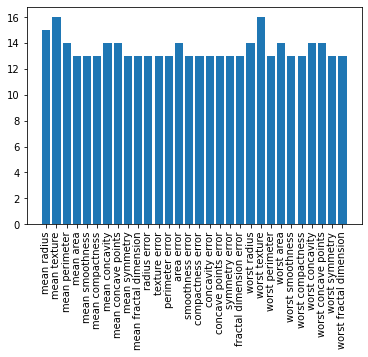

In [379]:
plt.bar(feature_names, clf_depth10.feature_importance)
plt.xticks(rotation=90)
plt.show()

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [380]:
# Store the random features we choose for the decision tree
class TreeInfo():
    def __init__(self, tree=None, choice_features=None):
        self.tree = tree
        self.choice_features = choice_features

In [381]:
class RandomForest():
    def __init__(self, n_estimators, max_features, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_features = int(max_features)
        self.bootstrap = bootstrap
        self.criterion = 'gini'
        self.max_depth = 3
        self.trees = []

    def build_forest(self, X, y):
        # Loop n_estimators times to build forest
        for _ in range(self.n_estimators):
            # Randomly choose max_feautres features
            choice_feat = np.random.choice(X.shape[1], size=self.max_features)
            choice_X = X[:, choice_feat]

            # Randomly choose 1/2 of data as new data
            if self.bootstrap:
                s = int(X.shape[0] / 2)
                choice_samples = np.random.choice(X.shape[0], size=s)
                choice_X = choice_X[choice_samples, :]
                choice_y = y[choice_samples, :]

            # Create decision tree
            c = self.criterion
            m = self.max_depth
            tree = DecisionTree(criterion=c, max_depth=m)
            tree.fit(choice_X, choice_y)
            tree_info = TreeInfo(tree, choice_feat)
            self.trees.append(tree_info)

    def predict(self, X):
        predictions = []
        # Loop through all data for prediction
        for obs in X:
            election = []
            # Loop through all of the trees to get the prediction of them
            for tree_info in self.trees:
                o = [obs[tree_info.choice_features]]
                election.append(tree_info.tree.predict(o)[0])
            # Vote and elect to get most common class
            predictions.append(Counter(election).most_common(1)[0][0])
        return np.array(predictions)

### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [388]:
mx = np.sqrt(x_train.shape[1])
clf_10tree = RandomForest(n_estimators=10, max_features=mx)
clf_100tree = RandomForest(n_estimators=100, max_features=mx)

In [389]:
clf_10tree.build_forest(x_train, y_train)
clf_100tree.build_forest(x_train, y_train)

In [390]:
print(accuracy_score(clf_10tree.predict(x_test), y_test))
print(accuracy_score(clf_100tree.predict(x_test), y_test))

0.9090909090909091
0.9300699300699301


### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [400]:
mx = np.sqrt(x_train.shape[1])
clf_random_features = RandomForest(n_estimators=10, max_features=mx)
mx = x_train.shape[1]
clf_all_features = RandomForest(n_estimators=10, max_features=mx)

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [401]:
clf_random_features.build_forest(x_train, y_train)
clf_all_features.build_forest(x_train, y_train)

In [402]:
print(accuracy_score(clf_random_features.predict(x_test), y_test))
print(accuracy_score(clf_all_features.predict(x_test), y_test))

0.9440559440559441
0.951048951048951


## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 